In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings('ignore', 'ValueWarning')
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.axis import Axis
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas.tseries.frequencies import to_offset
from statsmodels.base.data import PandasData
import statsmodels.base.model as base
import statsmodels.base.wrapper as wrap
from statsmodels.tools.sm_exceptions import ValueWarning

In [2]:
df = pd.read_csv('brasil.csv',  index_col=0, parse_dates=True)
df.index = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2555 entries, 2020-03-19 to 2021-12-07
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        2555 non-null   object
 1   date        2555 non-null   object
 2   deaths      2555 non-null   int64 
 3   state       2555 non-null   object
 4   deaths_day  2555 non-null   int64 
 5   month_year  2555 non-null   object
 6   region      2555 non-null   object
dtypes: int64(2), object(5)
memory usage: 159.7+ KB


In [3]:
df.drop(columns=['month_year', 'deaths'],inplace=True)
df['deaths_day'] = df['deaths_day'].astype('int32')

In [4]:
df2 = df[0:638]

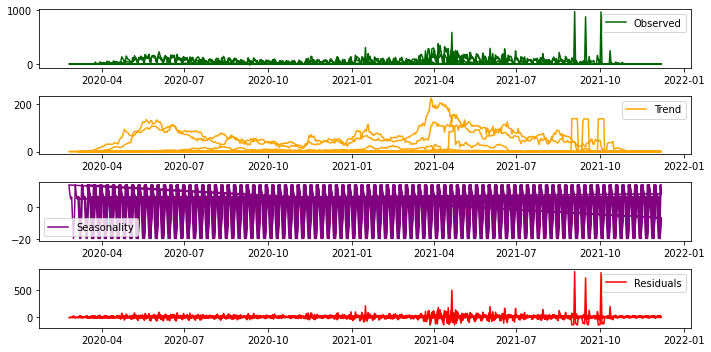

In [5]:
result = seasonal_decompose(df.deaths_day,period=7)
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(df.deaths_day,label='Observed', color='darkgreen')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(result.trend,label='Trend',color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality',color='purple')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(result.resid,label='Residuals',color='red')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('decomposition.jpg')

In [6]:
dftest = adfuller(df.deaths_day, autolag = 'AIC')
print('ADF Test for number of cumulative deaths.')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

ADF Test for number of cumulative deaths.
1. ADF :  -3.213795750168048
2. P-Value :  0.019199886561564097
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2527
5. Critical Values :
	 1% :  -3.4329404056582598
	 5% :  -2.862684432835292
	 10% :  -2.567379225007826


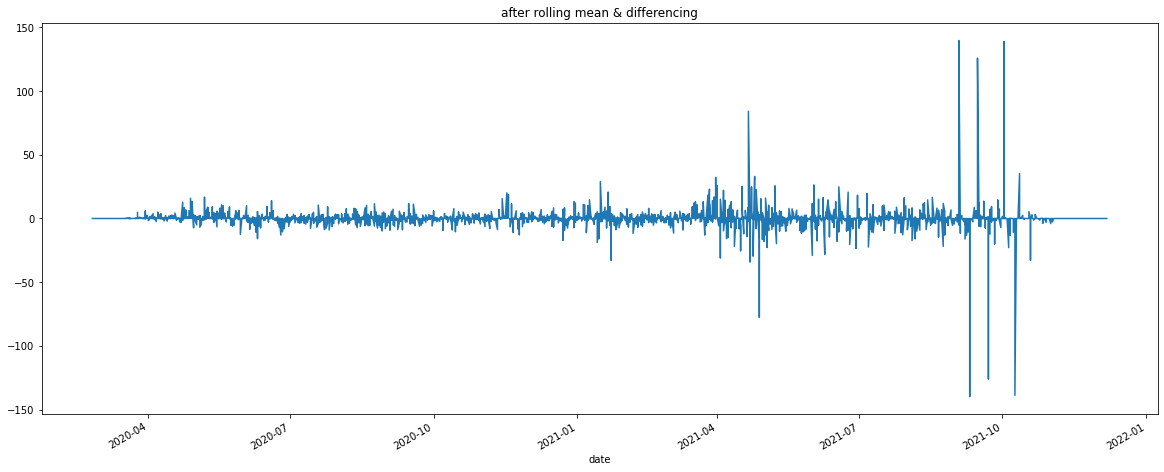

<Figure size 1440x576 with 0 Axes>

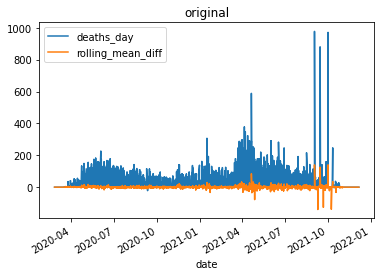

In [7]:
plt.figure(figsize=(20,8))
rolling_mean = df.deaths_day.rolling(window = 7).mean()
df['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
df['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
plt.figure(figsize=(20,8))
df.plot(title='original');


# date['mean_deaths'] = df.deaths.rolling(window=30, center=False).mean()
# #media morte cada 30 dias
# date['mean_deaths_day'] = date.deaths_day.rolling(window=12, center=False).mean()

In [8]:
dftest = adfuller(df['deaths_day'].dropna(), autolag = 'AIC')
print('ADF Test for number of daily deaths.')
print("1. P-Value : ", dftest[1])
print("2. Num Of Observations:", dftest[3])

ADF Test for number of daily deaths.
1. P-Value :  0.019199886561564097
2. Num Of Observations: 2527


## encontrar parametros

In [9]:
# identificar parametros de forma automatizada
import itertools

p = d= q = range(0,2)
pdq = list(itertools.product(p, d, q)) # vai fzaer a combinacao de todos os parametros
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Exemplo de combinacao de parametro para o SARIMAX:')
print('SARIMAX:{}x{}'.format(pdq[0], seasonal_pdq[0]))
print('SARIMAX:{}x{}'.format(pdq[0], seasonal_pdq[1]))
print('SARIMAX:{}x{}'.format(pdq[0], seasonal_pdq[2]))
#parametro nao sazonal x parametro  sazonal

Exemplo de combinacao de parametro para o SARIMAX:
SARIMAX:(0, 0, 0)x(0, 0, 0, 7)
SARIMAX:(0, 0, 0)x(0, 0, 1, 7)
SARIMAX:(0, 0, 0)x(0, 1, 0, 7)


In [10]:
y = df2.deaths_day
y.head(50)

date
2020-03-19    0
2020-03-20    0
2020-03-21    0
2020-03-22    0
2020-03-23    0
2020-03-24    0
2020-03-25    0
2020-03-26    0
2020-03-27    0
2020-03-28    0
2020-03-29    0
2020-03-30    0
2020-03-31    0
2020-04-01    0
2020-04-02    0
2020-04-03    2
2020-04-04    0
2020-04-05    0
2020-04-06    0
2020-04-07    0
2020-04-08    0
2020-04-09    0
2020-04-10    0
2020-04-11    0
2020-04-12    2
2020-04-13    2
2020-04-14    0
2020-04-15    0
2020-04-16    2
2020-04-17    0
2020-04-18    1
2020-04-19    0
2020-04-20    0
2020-04-21    0
2020-04-22    0
2020-04-23    1
2020-04-24    0
2020-04-25    1
2020-04-26    0
2020-04-27    1
2020-04-28    1
2020-04-29    2
2020-04-30    1
2020-05-01    2
2020-05-02    0
2020-05-03    2
2020-05-04    3
2020-05-05    1
2020-05-06    3
2020-05-07    3
Name: deaths_day, dtype: int64

## autocorelacao e correlacao parcial

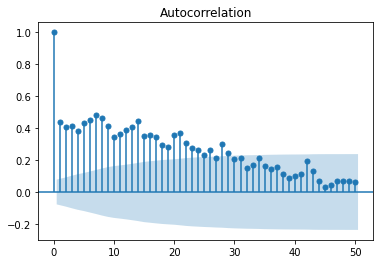

In [11]:
plot_acf(y, lags=50);
# Parameter Q

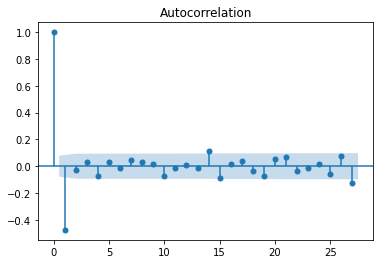

In [12]:
plot_acf(y.diff().dropna(), lags=27);

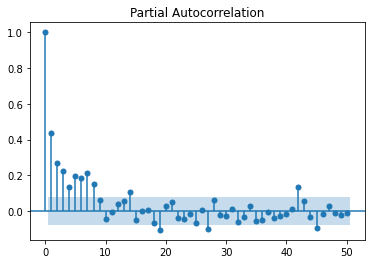

In [13]:
plot_pacf(y, lags=50);
#determina o parametreo q, ma.

## metricas mais importantes AIC, BIC
- aic - criterio de informacao arkaike. vai comparar o resultado obtido com modelo estatistico real
- bic - estimativa da probabilidade ser verdadeira, quanto menor, melhor.

ambas medidas de distancia. metricas complexas.


## SARIMAX
ARIMA
Juncao de 3 modelos, definicao de parametros:
- ar = auto regressivo (regressao linear com dados do passado) (p). numero de valores a adicionar. quanto mais valores, mais dados antigos.

- i =  integrado (diferenciacao) quantas diff teve que ser feita (d). quanto mais diff, maior o d.
- am = media movel - regressao linear (com erros de previsao com dados do passado) (q)

## SARIMA
usa-se quando há parcela de sazonalidade grande
- P
- D
- Q

In [14]:
aic_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(y,
                                   order=param, #parametro nao sazonal
                                   seasonal_order = param_seasonal) #parametro sazonal
        results = mod.fit()
        #aic_list.append('ARIMA{}x{} - AIC{}'.format(param, param_seasonal, result.aic))

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67518D+00    |proj g|=  8.10685D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   8.107D-07   2.675D+00
  F =   2.6751760622380019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.5

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   2.062D-06   2.470D+00
  F =   2.4700800559294214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47306D+00    |proj g|=  3.80267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   1.699D-06   2.473D+00
  F =   2.473041759245099

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

At iterate    5    f=  2.51171D+00    |proj g|=  2.19853D-03

At iterate   10    f=  2.51043D+00    |proj g|=  2.40607D-04

At iterate   15    f=  2.51039D+00    |proj g|=  6.22967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     20      1     0     0   4.718D-06   2.510D+00
  F =   2.5103896761205697     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53639D+00    |proj g|=  3.55623D-03

        

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28381D+00    |proj g|=  9.15006D-02

At iterate    5    f=  2.24415D+00    |proj g|=  9.57952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.687D-07   2.244D+00
  F =   2.2441453184616140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39043D+00    |proj g|=  1.52152D-01

At iterate    5    f=  2.31405D+00    |proj g|=  6.48610D-03

At iterate   10    f=  2.31204D+00    |proj g|=  9.58380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   9.458D-05   2.312D+00
  F =   2.3119501728105889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10



/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

At iterate   15    f=  2.22793D+00    |proj g|=  4.63973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   9.371D-06   2.228D+00
  F =   2.2278946791889562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36848D+00    |proj g|=  7.35447D-02

At iterate    5    f=  2.35020D+00    |proj g|=  6.02730D-05

           * * *

Tit   = total number of iterations
Tnf   = total num

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55712D+00    |proj g|=  7.29793D-02

At iterate    5    f=  2.53402D+00    |proj g|=  2.11183D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.112D-05   2.534D+00
  F =   2.5340224242957947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

In [15]:
y = df.deaths_day
mod = sm.tsa.statespace.SARIMAX(y, 
                                order=(1,1,1),
                                seasonal_order=(1,1,1,7))
results = mod.fit()

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A da

In [16]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        deaths_day   No. Observations:                 2555
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -13351.707
Date:                           Wed, 15 Dec 2021   AIC                          26713.414
Time:                                   23:13:33   BIC                          26742.628
Sample:                                        0   HQIC                         26724.010
                                          - 2555                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0145      0.017     -0.848      0.396      -0.048       0.019
ma.L1         -0.9161      0.006   -152.334

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


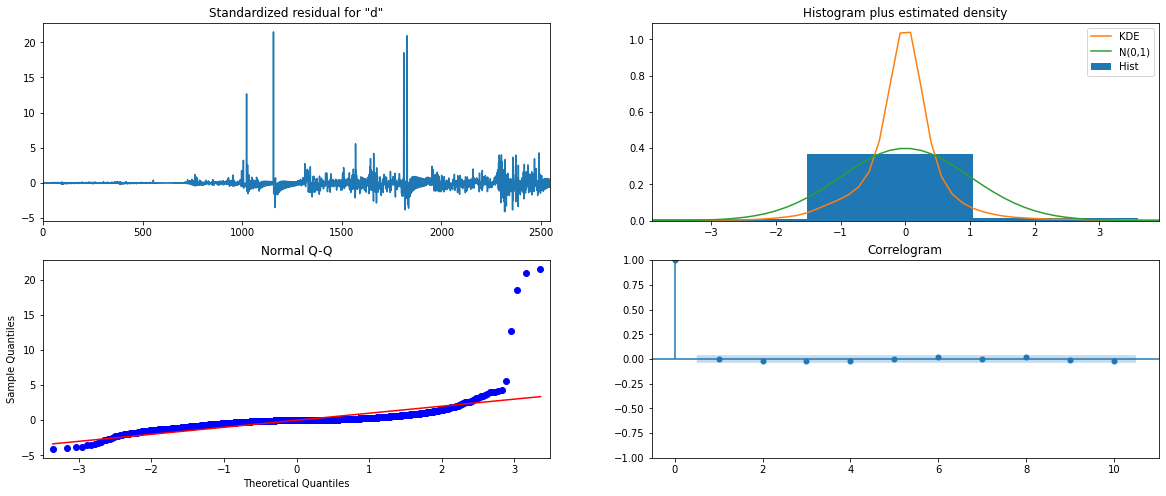

In [17]:
results.plot_diagnostics(figsize=(20,8));
plt.show()
#residuos: quanto mais casos, mais residuos
#histograma: kde, é a distribuicao dos residuos. ele esta razoavel
# correlograma: estao baixas, conseguiu transformar em estacionario
# grafico QQ, comparacao entre quantis, quanto mais proximo o modelo dos dados, 
#mais os pontinhos vao estar na linha vermelha. resultados dentro do esperado.

## training
usa-se para o treino um intervalo de datas

In [18]:
train = results.get_prediction(start=pd.to_datetime('2020-10-02'), dynamic=False)
train_interval = train.conf_int()# setting interval confidence 
train_interval

,lower deaths_day,upper deaths_day
date,,
2020-10-02,-89.288433,89.646689
2020-10-03,-89.385864,89.546047
2020-10-04,-89.805832,89.123384
2020-10-05,-88.959061,89.967895
2020-10-06,-89.025416,89.899646
...,...,...
2021-12-03,-84.686332,94.090201
2021-12-04,-107.858768,70.917765
2021-12-05,-112.159884,66.616649


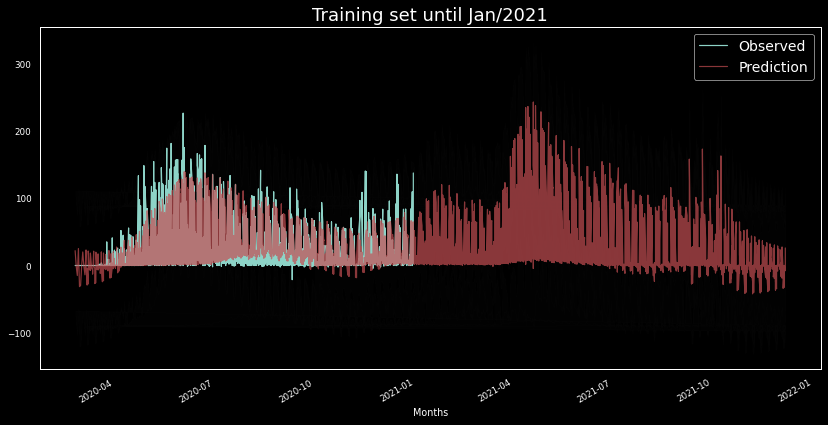

In [19]:
sns.set(style="dark", context="paper")
plt.style.use("dark_background")
ax = y['2020'].plot(label='Observed') #observed cases from 2020
train.predicted_mean.plot(ax=ax, label='Prediction', color='r', alpha=0.7, figsize=(14,7)) 
#average median
ax.fill_between(train_interval.index, train_interval.iloc[:,0], train_interval.iloc[:,1], color='k', alpha=0.1) 
# confidence interval
ax.set_xlabel('Months')
ax.set_title('Training set until Jan/2021', fontsize=18)
plt.legend(fontsize=14)
plt.show()

## Prediction to unknown data / testing

In [32]:
#test = results.get_prediction()
test = results.get_forecast()
test_interval = test.conf_int()
test_interval

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,lower deaths_day,upper deaths_day
2555,-81.819133,96.9574


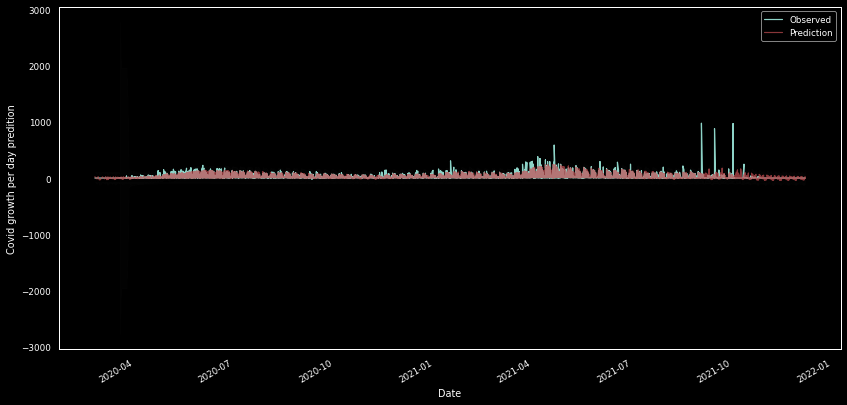

In [25]:
ax = y.plot(label='Observed', figsize=(14,7))
test.predicted_mean.plot(ax=ax, label='Prediction', color='r', alpha=0.7, figsize=(14,7)) 
#media movel da predicao
ax.fill_between(test_interval.index, test_interval.iloc[:,0], test_interval.iloc[:,1], color='k', alpha=0.1) 
# preenchendo o intervalo de confianca
ax.set_xlabel('Date')
ax.set_ylabel('Covid growth per day predition')
plt.legend()
plt.show()

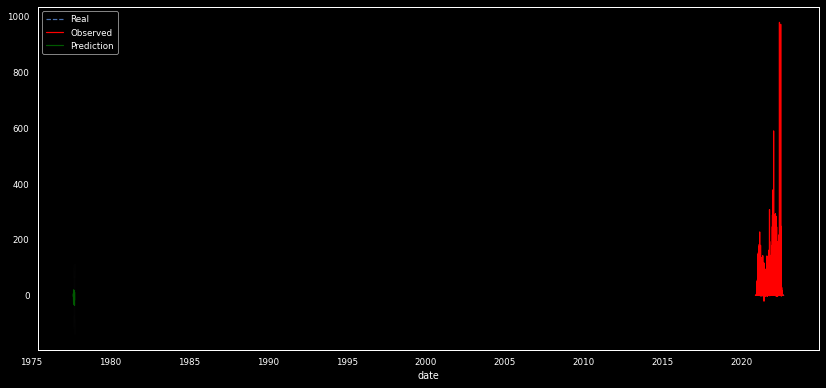

In [22]:
## VALIDATION

x = df2['deaths_day']
plt.figure(figsize=(20,7))
fig = plt.plot(x, linestyle='--', color = 'b', label ='Real')
ax = y.plot(label='Observed', color='red',figsize=(14,7))
test.predicted_mean.plot(ax=ax, label='Prediction', color='green', alpha=0.7) 
ax.fill_between(test_interval.index, test_interval.iloc[:,0], test_interval.iloc[:,1], color='k', alpha=0.1) 
#media movel da predicao
# preenchendo o intervalo de confianca
plt.legend()
plt.show()

/home/dci-pc-ubuntu41/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


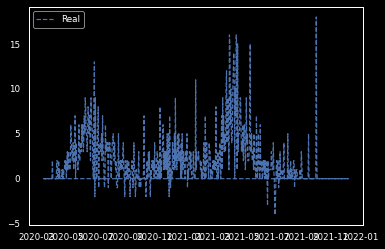

In [23]:
validation = results.get_forecast(steps=30)
val_interval = validation.conf_int()
x = df2['deaths_day']

fig = plt.plot(x, linestyle='--', color = 'b', label ='Real')

validation.predicted_mean.plot(ax=ax, label='Prediction', color='r', alpha=0.7, figsize=(14,7)) 
#media movel da predicao
ax.fill_between(test_interval.index, test_interval.iloc[:,0], test_interval.iloc[:,1], color='k', alpha=0.1) 
# preenchendo o intervalo de confianca
ax.set_xlabel('Date')
ax.set_ylabel('Covid growth per day predition')
plt.legend()
plt.show()